<a href="https://colab.research.google.com/github/py-tonic/dacon_landmark/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
from glob import glob
import random
import shutil
import natsort as nt
import matplotlib.pyplot as plt
import numpy as np
import unicodedata

In [ ]:
os.chdir('/content/gdrive/My Drive/dacon/public')
path_train = os.path.join(os.getcwd(),'train')
path_cate_csv = os.path.join(os.getcwd(),'category.csv')
df_cate = pd.read_csv(path_cate_csv)
df_cate.head()

,landmark_id,landmark_name
0,0,금천구청
1,1,두리랜드
2,2,이대원 장군묘
3,3,성공회대학교
4,4,송상현공 동상


In [ ]:
category = dict(df_cate.values[:,::-1])

In [ ]:
%%time
train_list = glob(os.path.join(path_train,'*','*','*.JPG'))

CPU times: user 553 ms, sys: 254 ms, total: 807 ms
Wall time: 2min 56s


In [ ]:
def load_class_idx_from_path(img_path, category_dict):
    filename = os.path.basename(img_path)
    class_name = unicodedata.normalize('NFC',' '.join(filename.split('_')[:-1]))
    #print(filename)
    #print(class_name)
    if class_name == '이케아 광명':
        class_name = '이케아_광명'
    if class_name == '이케아 고양':
        class_name = '이케아_고양'
    return category_dict[class_name]

path_train_new = os.path.join(os.getcwd(), 'train_new')

def make_folder(folder_name):
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
make_folder(path_train_new)

In [ ]:
%%time
for i in range(len(category)):
    path_train_class = os.path.join(path_train_new, str(i))
    make_folder(path_train_class)

for i, image in enumerate(train_list):
    idx = image.rfind('/')
    image_name = image[idx:]
    class_id = load_class_idx_from_path(image, category)
    path_shutil = os.path.join(path_train_new, str(class_id)  + image_name)

    try:
        shutil.move(image, path_shutil)
    except FileNotFoundError:
        pass

CPU times: user 19.1 s, sys: 27.5 s, total: 46.6 s
Wall time: 5min 58s


In [ ]:
class_list = nt.natsorted(os.listdir(path_train_new))
class_id_list = []
image_len_list = []
for i in range(len(class_list)):
    path_train_image = os.path.join(path_train_new, class_list[i])
    image_list = os.listdir(path_train_image)
    class_id_list.append(i)
    image_len_list.append(len(image_list))

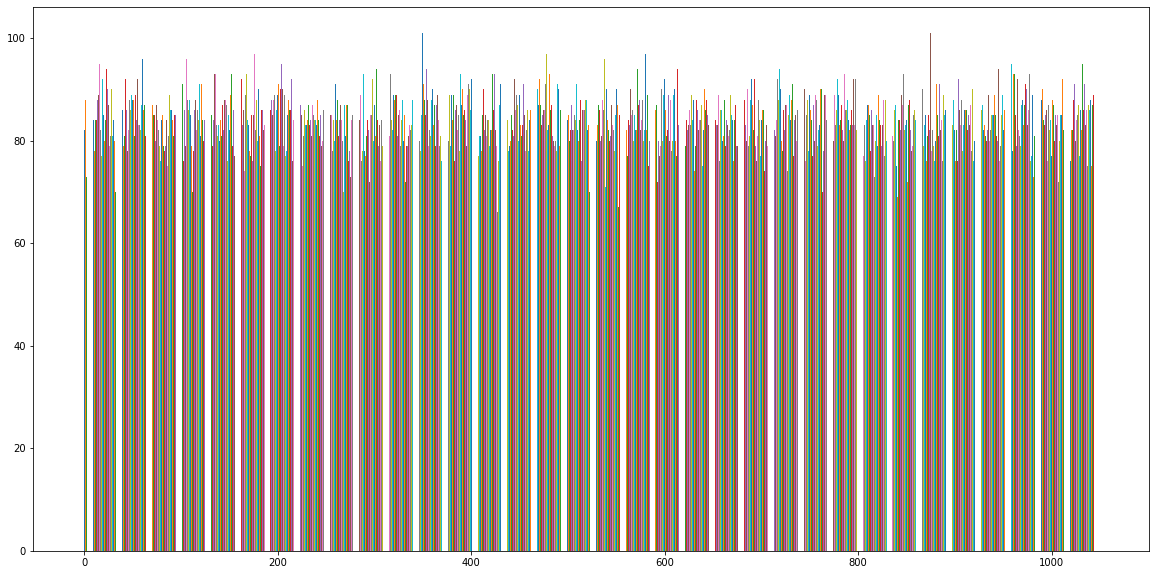

In [ ]:
cmap = plt.cm.tab10
colors = cmap(np.arange(len(class_id_list)) % cmap.N)
plt.figure(figsize=(20,10))
plt.bar(class_id_list,image_len_list, color=colors)
plt.show()

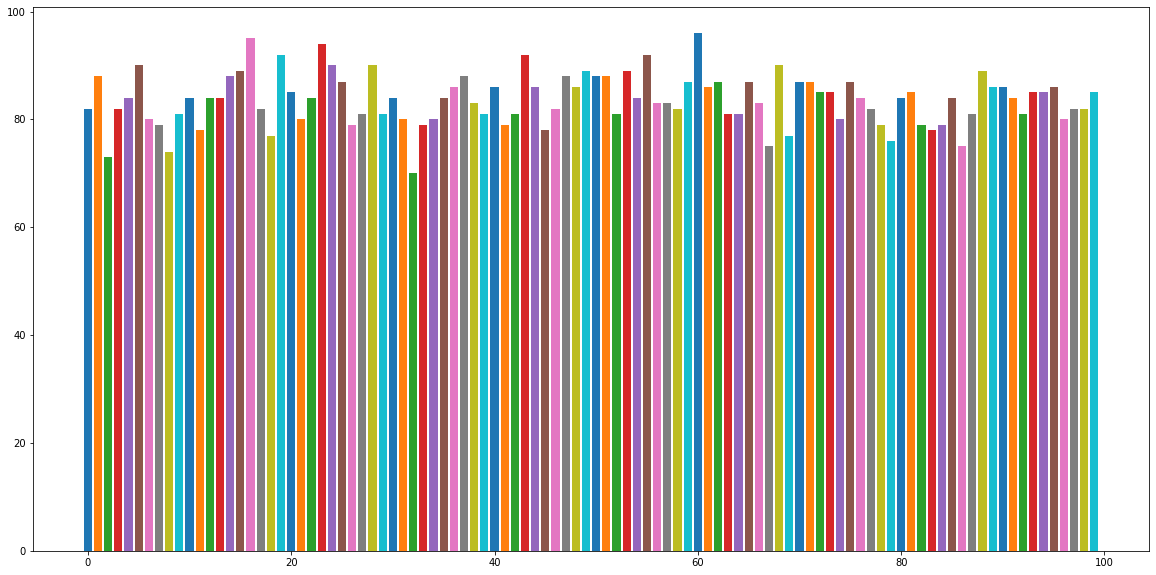

In [ ]:
cmap = plt.cm.tab10
colors = cmap(np.arange(len(class_id_list)) % cmap.N)
plt.figure(figsize=(20,10))
plt.bar(class_id_list[0:100],image_len_list[0:100], color=colors)
plt.show()

#Training code from here!

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image
import os
import pandas as pd
import numpy as np

os.chdir('/content/gdrive/My Drive/dacon/public')

In [ ]:
def escape_unicode(input_str: str):
    result = input_str.replace('#U', '\\u')     \
                      .encode('utf-8')          \
                      .decode('unicode_escape')
    return result

In [ ]:
class Dacon(Dataset):
    def __init__(self, transform=None):
        csv_file_path = os.path.join(os.getcwd(),'train.csv')
        self.csv_data = pd.read_csv(csv_file_path, header=0)
        self.image_paths = sorted(list(Path(os.getcwd()+'/train_new').rglob('*.JPG')))
        
        label_cnt = len(self.csv_data.index)
        image_cnt = len(self.image_paths)
        assert label_cnt == image_cnt
        self.length = label_cnt
        self.transform = transform
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        img = np.array(img)
        if self.transform:
            img = self.transform(img)
        #Get Label
        img_id = '.'.join(img_path.name.split('.')[:-1])
        img_id = unicodedata.normalize('NFC',img_id)
        label = self.csv_data.loc[self.csv_data['id']== img_id]['landmark_id'].item()
        label = np.array(label)
        #Make Sample
        sample = {
            'img': img,
            'img_id': img_id,
            'label': label
        }
        return sample

In [ ]:
dataset = Dacon(transform=transforms.ToTensor())
print(f'Data Count: {len(dataset)}')
print(dataset[0])

Data Count: 88102
{'img': tensor([[[0.8431, 0.8392, 0.8392,  ..., 0.1647, 0.2392, 0.2588],
         [0.8471, 0.8471, 0.8471,  ..., 0.2824, 0.3176, 0.3020],
         [0.8471, 0.8471, 0.8471,  ..., 0.7255, 0.5569, 0.3647],
         ...,
         [0.4824, 0.5176, 0.4863,  ..., 0.5137, 0.5294, 0.5373],
         [0.5059, 0.4824, 0.4745,  ..., 0.5216, 0.5216, 0.5569],
         [0.4824, 0.4706, 0.4314,  ..., 0.7137, 0.8000, 0.8275]],

        [[0.8235, 0.8196, 0.8196,  ..., 0.1647, 0.2353, 0.2549],
         [0.8275, 0.8275, 0.8275,  ..., 0.2745, 0.3059, 0.2902],
         [0.8275, 0.8275, 0.8275,  ..., 0.7137, 0.5451, 0.3529],
         ...,
         [0.4667, 0.5020, 0.4706,  ..., 0.4902, 0.4941, 0.5020],
         [0.4902, 0.4667, 0.4588,  ..., 0.4902, 0.4902, 0.5255],
         [0.4667, 0.4549, 0.4157,  ..., 0.6824, 0.7686, 0.7882]],

        [[0.8471, 0.8431, 0.8431,  ..., 0.2118, 0.2902, 0.3098],
         [0.8510, 0.8510, 0.8510,  ..., 0.3294, 0.3725, 0.3569],
         [0.8510, 0.8510, 0.8510